In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set_style("ticks")

from sklearn.neighbors import KernelDensity

### Read table, columns, define data

In [2]:
s = pd.read_csv("substructures2.txt", delimiter="|", header=7)

In [3]:
ra_s = s["RA"]
dec_s = s["DEC"]
z_s = s["Redshift"]
obj_name = s["Object Name"]

In [4]:
table = pd.read_csv("tables_photometric/Hydra-Centaurus-probgal&isoarea.csv", 
                    usecols=["RA", "DEC", "PROB_GAL", "zml", "r_petro", "g_petro"])

In [5]:
ra = table["RA"]
dec = table["DEC"]
probgal = table["PROB_GAL"]
zml = table["zml"]
rpetro = table["r_petro"]
gpetro = table["g_petro"]

In [6]:
mlim = 20
ra_max = 180
ra_min = 150
dec_min = -48
dec_max = -20

mask = (rpetro < mlim) & (zml > 0.005) & (zml < 0.03) & (ra < ra_max) & (ra 
                    > ra_min) & (dec > dec_min) & (dec < dec_max)

mask_s = (ra_s < ra_max) & (ra_s > ra_min) & (z_s < 0.02) & (dec_s > dec_min) & (dec_s < dec_max)

### Transform coordinates from (RA, DEC) to euclidiean (x, y)
Not need anymore. I can simply use the haversine metric to compute distances directly over RA,DEC coordinates

In [8]:
from astropy import units as u
from astropy.coordinates import SkyCoord, spherical_to_cartesian

In [9]:
def convert_to_cartesian(ra, dec):
    x, y, z = spherical_to_cartesian(r=1, lon=np.deg2rad(ra), lat=np.deg2rad(dec))
    return x, y, z

In [33]:
x, y, z = convert_to_cartesian(ra[mask], dec[mask])

Text(0.5, 0, 'x')

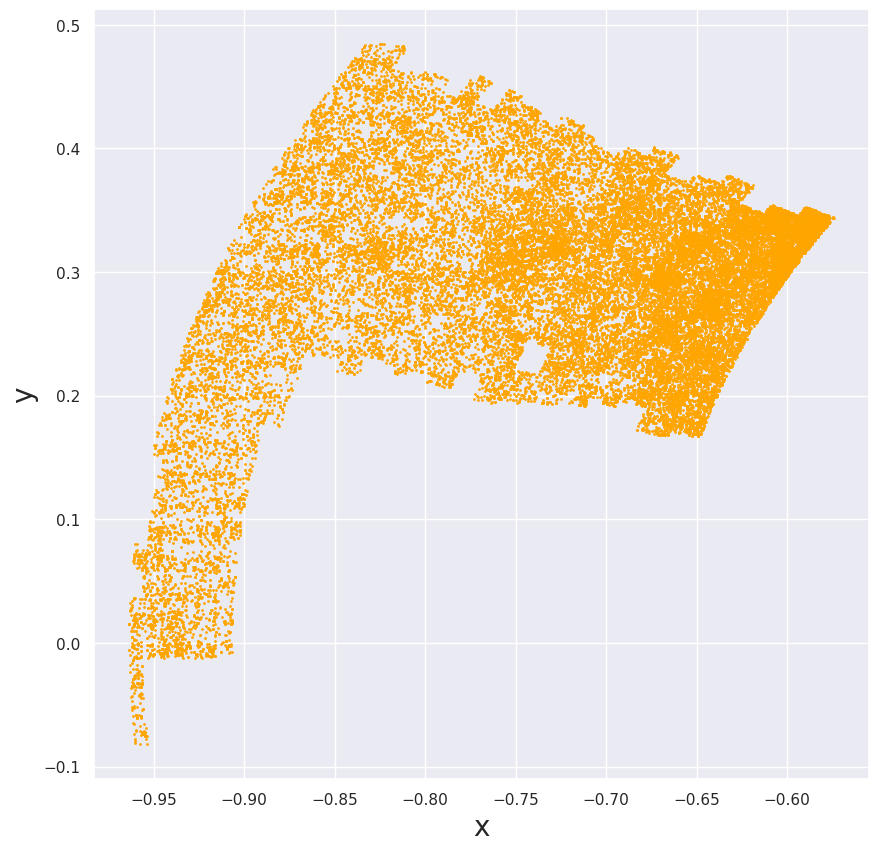

In [34]:
fontsize = 20
labelsize = 20

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
# sc1 = ax.scatter(ra[mask], dec[mask], s=5, color='blue', label="ICRS")
ax.scatter(x, y, s=1, color='orange', label="Cartesian")
ax.set_ylabel("y", fontsize=fontsize)
ax.set_xlabel("x", fontsize=fontsize)

### Apply cross-validation to search for best value of bandwidth
I am not completelly sure yet is this is the correct way of running the grid search for the best bandwidth

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

In [125]:
x = np.deg2rad(ra[mask]) #like longitude
y = np.deg2rad(dec[mask]) #like latitude

xbin_size = 200
ybin_size = 200

xbins=xbin_size*1j
ybins=ybin_size*1j

xx, yy = np.mgrid[x.min():x.max():xbins, y.min():y.max():ybins]

In [10]:
bandwidths = np.linspace(0.005, 0.04, 100)

def calculate_bandwidth(bandwidth_array):
    grid = GridSearchCV(KernelDensity(kernel='epanechnikov', metric='haversine'),
                        {'bandwidth': bandwidth_array},
                        cv=LeaveOneOut())

    X_train = np.vstack([y, x]).T #The same training set I use when running KernelDensity()
    grid.fit(X_train)
    
    print("grid.best_params = ", grid.best_params_)
    
    results = pd.DataFrame(grid.cv_results_)
    results.replace([np.inf, -np.inf], 0, inplace=True)
    
    return results, grid.best_params_


#Use multiprocessing to calculate the bandwidth
import multiprocessing as mp

pool = mp.Pool(mp.cpu_count())
results, bandwidth = pool.apply(calculate_bandwidth, args=(bandwidths, ))
pool.close()

/home/elismar/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:969: UserWarning: One or more of the test scores are non-finite: [      -inf       -inf       -inf       -inf       -inf       -inf
       -inf       -inf       -inf 2.6458543  2.64290027 2.63989404
 2.63702557 2.63420037 2.63136766 2.62851083 2.62563468 2.62277501
 2.61998857 2.61725131 2.61461226 2.61200151 2.60940172 2.6068336
 2.6043035  2.6018115  2.59937614 2.59697369 2.59460583 2.59225857
 2.5898939  2.58752145 2.58514515 2.58276406 2.58038863 2.57802573
 2.57568335 2.5733606  2.57105359 2.56876581 2.56649851 2.56424255
 2.56200965 2.5597965  2.55759922 2.55541557 2.5532561  2.55112129
 2.54901483 2.54692359 2.54485176 2.54280663 2.54077484 2.53876049
 2.53676312 2.53479448 2.53284637 2.53090903 2.52898347 2.52707215
 2.52516983 2.52327427 2.52138112 2.51949152 2.51760585 2.51572613
 2.51384848 2.51198006 2.51011624 2.50826274 2.50641867 2.50457917
 2.50274295 2.50090927 2.49908118 2.49725847 

grid.best_params =  {'bandwidth': 0.008181818181818182}


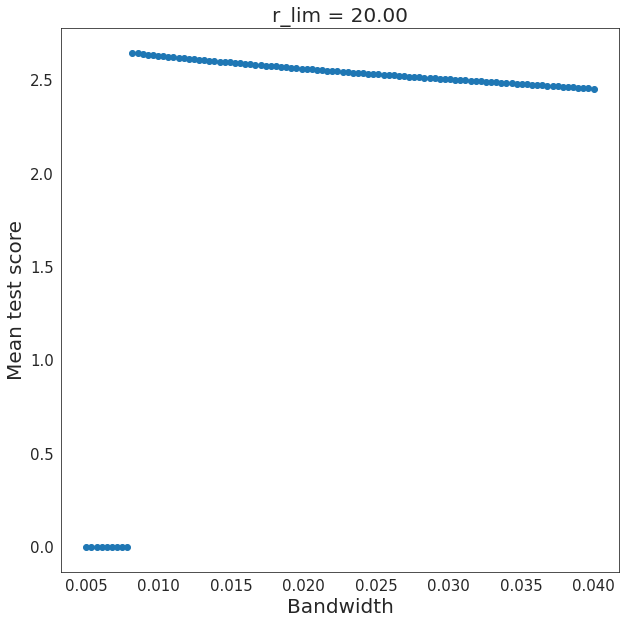

In [12]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.scatter(results["param_bandwidth"], results["mean_test_score"], marker='o')
ax.set_xlabel("Bandwidth", fontsize=20)
ax.set_ylabel("Mean test score", fontsize=20)
ax.set_title("r_lim = {:.2f}".format(mlim), fontsize=20)

ax.xaxis.set_tick_params(labelsize=15, width=35)
ax.yaxis.set_tick_params(labelsize=15, width=35)

### Kernel density estimation

In [8]:
def kde2D(x, y, bandwidth, xbins=100j, ybins=100j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""

    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[x.min():x.max():xbins, 
                      y.min():y.max():ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, kernel='epanechnikov', metric='haversine',
                                                    algorithm="ball_tree", **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)

In [9]:
#This bandwidth is the one I calculate before for Hydra-Centaurus data, but I think I need to recalculate it, because
#0.015 was just the smaller value in the array of possible bandwidths to be tested, so I have to test with lower values
bandwidth = 0.015
xx, yy, zz = kde2D(x, y, bandwidth=bandwidth, xbins=xbins, ybins=ybins)

In [10]:
cl_names = ["N3393", "A1060", "N3054", "N3087", "Antlia", "N3347", "N3250", "N3256", "N3263"]

cl_ras = [162.09, 159.17, 148.61, 149.78, 157.51, 160.69, 156.63, 156.96, 157.30]

cl_decs = [-25.16, -27.52, -25.70, -34.22, -35.32, -36.35, -39.94, -43.90, -44.12]

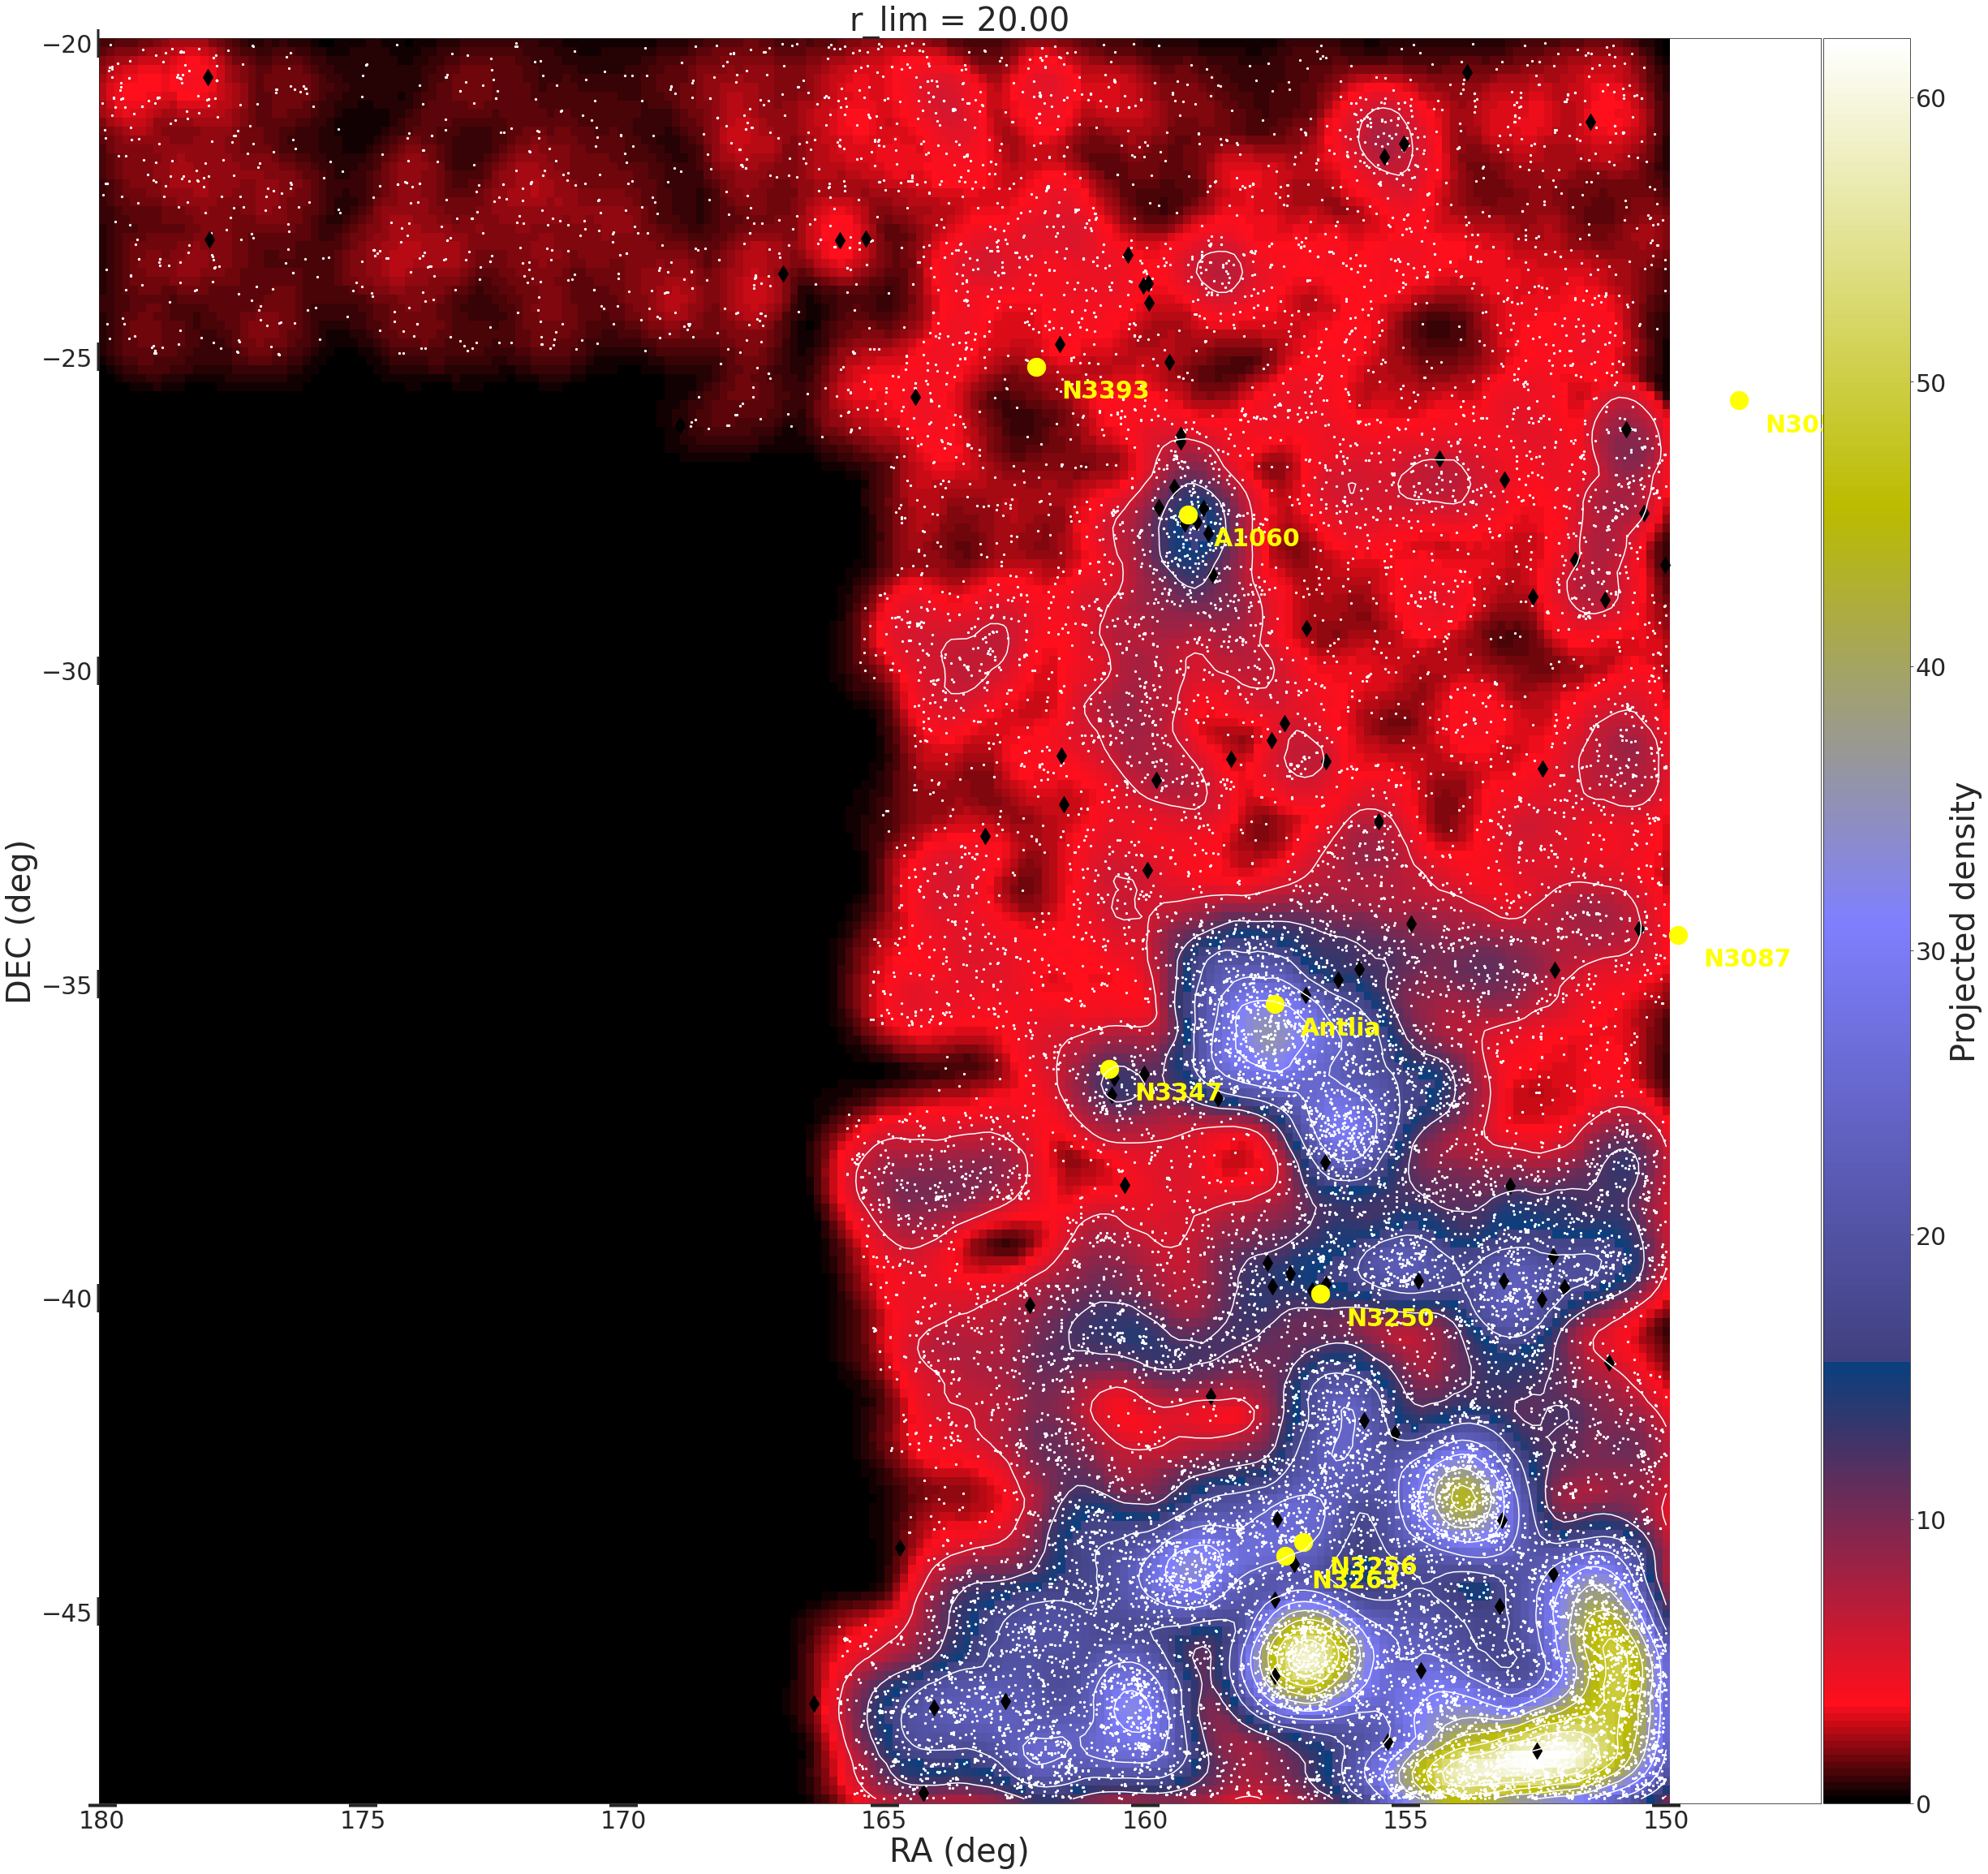

In [11]:
fontsize = 40
labelsize = 30

fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111)
sc1 = ax.pcolormesh(np.rad2deg(xx), np.rad2deg(yy), zz, cmap='gist_stern')
ax.scatter(np.rad2deg(x), np.rad2deg(y), s=5, color='white')
ax.set_title("Bandwidth = {:.4f}".format(bandwidth), fontsize=fontsize)
ax.set_ylabel("DEC (deg)", fontsize=fontsize)
ax.set_xlabel("RA (deg)", fontsize=fontsize)
ax.set_title("r_lim = {:.2f}".format(mlim), fontsize=40)

ax.scatter(x=ra_s[mask_s], y=dec_s[mask_s], s=200, color="black", marker="d")
ax.contour(np.rad2deg(xx), np.rad2deg(yy), zz, colors='white', levels=10, extend='min')


from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="Projected density", fontsize=fontsize)
cbar.ax.tick_params(labelsize=labelsize)

# ax.legend(fontsize=fontsize*0.8)
ax.xaxis.set_tick_params(labelsize=labelsize, width=35)
ax.yaxis.set_tick_params(labelsize=labelsize, width=35)

dx = 0.5
# for ra, dec, text in zip(ra_s[m], dec_s[m], obj_name[m]):
#     ax.text(ra-dx, dec-dx, s=text, fontsize=30, fontweight='bold', color='yellow')

for ra_i, dec_i, text in zip(cl_ras, cl_decs, cl_names):
    ax.scatter(ra_i, dec_i, marker='o', s = 500, color="yellow")
    ax.text(ra_i-dx, dec_i-dx, s=text, fontsize=30, fontweight='bold', color='yellow')
    
ax.invert_xaxis()

In [17]:
m = np.isin(obj_name, ["ABELL S0622", "ABELL S0628", "ABELL S0631", "Hydra CLUSTER", "KLEMOLA 13", 
                 "ABELL S0636", "ABELL S0639"])

In [16]:
m1 = (dec_s > -41) & (dec_s < -38) & (ra_s < 154) & (ra_s > 150) & (z_s < 0.1)

obj_name[m1]

376         ABELL S0622
400            SSCC 216
424         ABELL S0628
437            SSCC 220
438            SSCC 219
445           LDCE 0708
452           HDCE 0566
453         ABELL S0631
468           HDCE 0568
471    [STH2017] 112253
Name: Object Name, dtype: object

In [17]:
m2 = (dec_s > -29) & (dec_s < -27) & (ra_s < 162) & (ra_s > 158) & (z_s < 0.1)

obj_name[m2]

685        KLEMOLA 13
691      [DZ2015] 261
697      [DZ2015] 270
703         HDCE 0596
709     Hydra CLUSTER
713      [DZ2015] 267
724           HCG 048
735    [TSK2008] 0487
Name: Object Name, dtype: object

In [19]:
m3 = (dec_s > -36) & (dec_s < -34) & (ra_s < 158) & (ra_s > 156) & (z_s < 0.1)

obj_name[m3]

597      [STH2017] 100014
618      [STH2017] 101382
637    PSZ2 G272.88+19.14
645           ABELL S0636
646    Antlia GROUP NED02
Name: Object Name, dtype: object

In [22]:
m4 = (dec_s > -48) & (dec_s < -46) & (ra_s < 162) & (ra_s > 159) & (z_s < 0.1)

obj_name[m4]

748      HDCE 0600
751    ABELL S0639
765       SSCC 224
766       SSCC 223
Name: Object Name, dtype: object

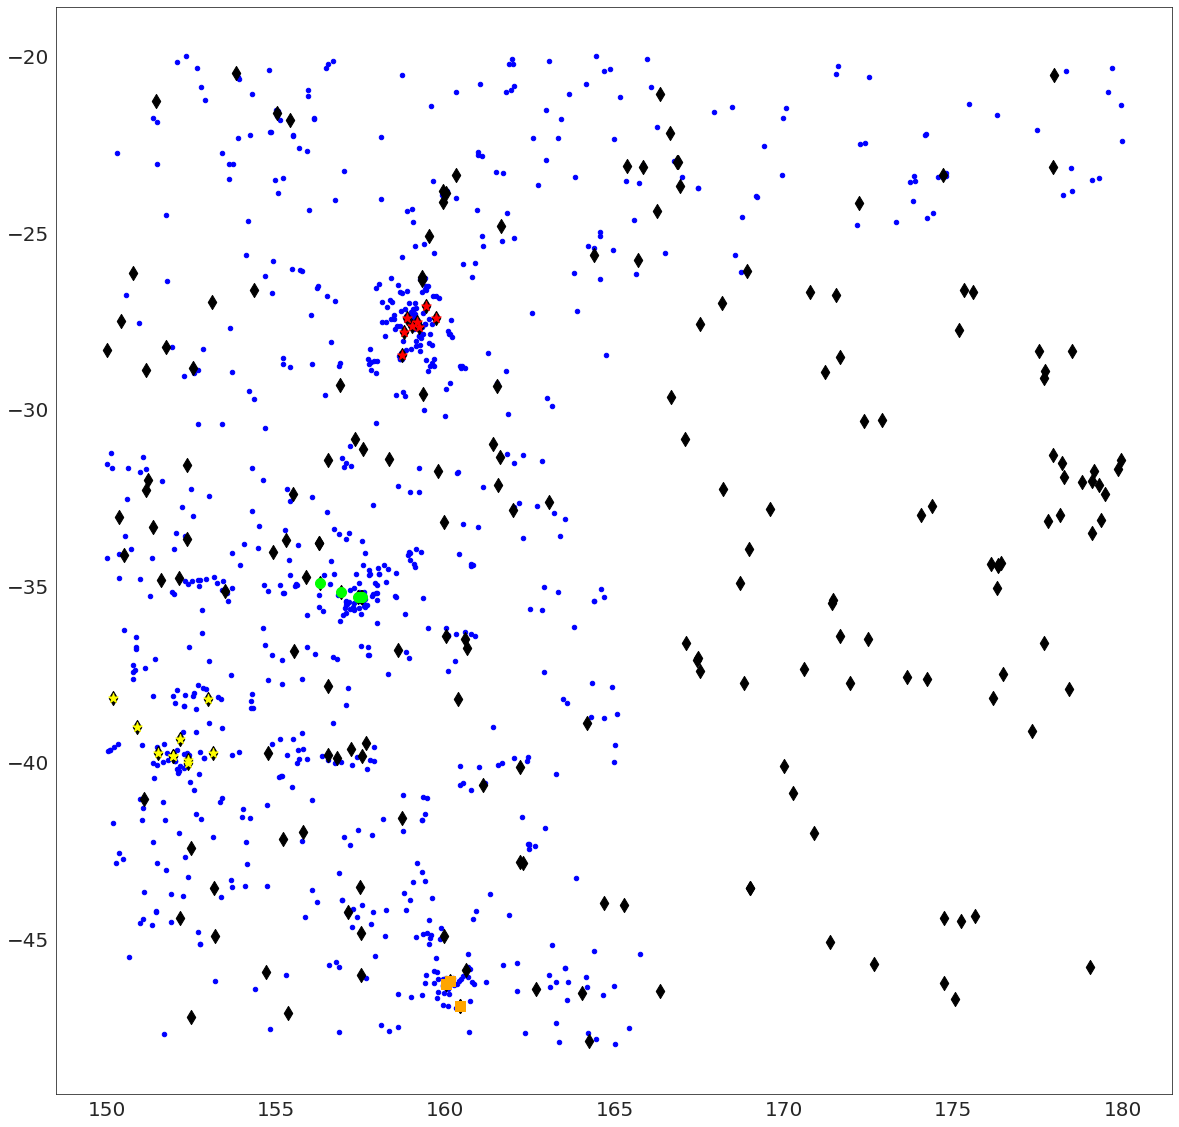

In [24]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
ax.scatter(np.rad2deg(x), np.rad2deg(y), s=20, color='blue')
ax.scatter(x=ra_s[mask_s], y=dec_s[mask_s], s=100, color="black", marker="d")

ax.scatter(x=ra_s[m1], y=dec_s[m1], s=100, color="yellow", marker="*")
ax.scatter(x=ra_s[m2], y=dec_s[m2], s=100, color="red", marker="*")
ax.scatter(x=ra_s[m3], y=dec_s[m3], s=100, color="lime", marker="o")
ax.scatter(x=ra_s[m4], y=dec_s[m4], s=100, color="orange", marker="s")

ax.xaxis.set_tick_params(labelsize=20, width=35)
ax.yaxis.set_tick_params(labelsize=20, width=35)

### Calculate KDE by hand to see if sklearn is doing it right
We have to calculate the KDE for a given point and compare with the KDE computed by sklearn

In [38]:
def sph_dist(alpha1, delta1, alpha2, delta2):
    '''
    Calculate the distance between two points over a spherical surface
    
    Parameters
    -----------
    alpha1: float
    right ascencion of point 1
    
    delta1: float
    declination of point 1
    
    alpha2: float
    right ascencion of point 2
    
    delta2: float
    declination of point 2
    '''
    return np.sqrt((alpha2 - alpha1)**2 + np.cos(delta1)*np.cos(delta2)*(delta2 - delta1)**2)

In [69]:
def sph_dist2(alpha1, delta1, alpha2, delta2):
    '''
    Calculate the distance between two points over a spherical surface (this one is more precise)
    
    Parameters
    -----------
    alpha1: float
    right ascencion of point 1
    
    delta1: float
    declination of point 1
    
    alpha2: float
    right ascencion of point 2
    
    delta2: float
    declination of point 2
    '''
    return np.arccos(np.sin(delta1)*np.sin(delta2) + np.cos(delta1)*np.cos(delta2)*np.cos(alpha2-alpha1))

Haversine metric: have a look at https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html

In [31]:
def haversine(x1, y1, x2, y2):
    '''
    Calculate the distance between points (x1, y1) and (x2, y2) using haversine metric
    
    Basically, x1 and x2 are the right ascencions, and y1 and y2 are the declinations
    '''
    
    return 2*np.arcsin(np.sqrt(np.sin((x2-x1)/2)**2 + np.cos(x1)*np.cos(x2)*np.sin((y2-y1)/2)**2))

In [164]:
def epanechnikov(x):
    '''
    Epanechnikov Kernel
    '''
    return (3/4)*(1 - x**2)

In [200]:
i = 30
j = 40

ra_test = xx[i, j] #X position (RA)
dec_test = yy[i, j] #Y position (DEC)

In [201]:
# distances = sph_dist2(ra_test, dec_test, x, y)
distances = haversine(ra_test, dec_test, x, y)
mask = (distances / bandwidth) <= 1
N = len(x)
D = 2 #Two-dimensional space

kde_test = 1/(N*bandwidth**D) * np.sum(epanechnikov(distances[mask]/bandwidth))

print("The KDE at (x, y) = ({:.2f}, {:.2f}) is {:.3f}".format(ra_test, dec_test, kde_test))

The KDE at (x, y) = (2.79, -0.61) is 5.921


In [202]:
print("The KDE at (x, y) = ({:.2f}, {:.2f}), by sklearn, is {:.3f}".format(ra_test, dec_test, zz[i, j]))

The KDE at (x, y) = (2.79, -0.61), by sklearn, is 6.172


### Calculate the density contrast in several regions of the Supercluster

The density contrast is defined by <br>

$$
\delta = \frac{\Sigma - \bar{\Sigma}}{\bar{\Sigma}} = \frac{\Sigma}{\bar{\Sigma}} -1 
$$

where $\Sigma$ is the density at a certain point or region, and $\bar{\Sigma}$ is the mean density at a reference region. Here, our idea is to consider a series of rings around the center of certain overdense regions, calculate the median density of the outermost ring, and use the median density of the others rings to calculate the contrast density as a function of the radius.

In [77]:
#Defining the center of Hydra (in degress)
ra_0 = np.deg2rad(159.17)
dec_0 = np.deg2rad(-27.524)

#Defining the radius of 1R200 around the center (in degrees)
#R200 = 1.4Mpc + scale of 0.247 Kpc/" ==> radius = 1.5744º
hydra_radius = np.deg2rad(1.5744)

In [78]:
distances_from_hydra_center = haversine(ra_0, dec_0, xx, yy)

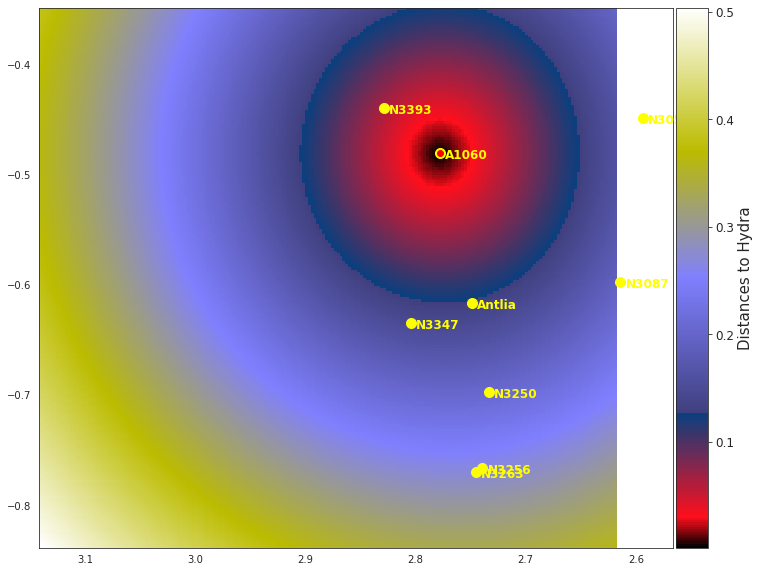

In [80]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.plot(ra_0, dec_0, marker='o', color='red')
sc1 = ax.pcolormesh(xx, yy, distances_from_hydra_center, cmap='gist_stern')

divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="Distances to Hydra", fontsize=15)
cbar.ax.tick_params(labelsize=12)

dx = 0.005
for ra_i, dec_i, text in zip(np.deg2rad(cl_ras), np.deg2rad(cl_decs), cl_names):
    ax.scatter(ra_i, dec_i, marker='o', s = 100, color="yellow")
    ax.text(ra_i-dx, dec_i-dx, s=text, fontsize=12, fontweight='bold', color='yellow')

ax.set_aspect("equal")
ax.invert_xaxis()

In [86]:
dr = hydra_radius / 10
radii = np.arange(dr, 5*hydra_radius, dr)

density_r = []
for i in range(1, len(radii)):
    annulus_i = (distances_from_hydra_center > radii[i-1]) & (distances_from_hydra_center < radii[i])
    
    median_density_inside_annulus = np.median(zz[annulus_i])
    density_r.append(median_density_inside_annulus)
    
density_r = np.asarray(density_r)
contrast_density = (density_r - density_r[-1]) / density_r[1]

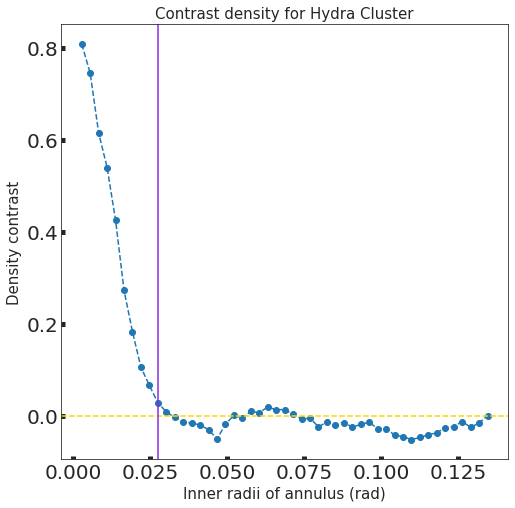

In [122]:
fontsize=15
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

ax.plot(radii[:-1], contrast_density, '--o')
ax.set_title("Density contrast for Hydra Cluster", fontsize=fontsize)
ax.set_xlabel("Inner radii of annulus (rad)", fontsize=fontsize)
ax.set_ylabel("Density contrast", fontsize=fontsize)

ax.axhline(y=0, color="gold", linestyle='--')
ax.axvline(x=hydra_radius, color="blueviolet")

ax.xaxis.set_tick_params(labelsize=20, width=5, direction='in')
ax.yaxis.set_tick_params(labelsize=20, width=5, direction='in')

#### In order to calculate the density contrast for all Hydra-Centaurus, we will need to estimate the local background density at each point, so that we can use it as our "reference" density ($\bar{\Sigma}$) 

One idea is to estimate the background at several different points of the Supercluster, in which there are no apparent overdensities or underdensities, and then use a 2D interpolation to extrapolate it for all the region.

In [104]:
from scipy import interpolate

In [105]:
x_example = np.arange(-5.01, 5.01, 0.25)
y_example = np.arange(-5.01, 5.01, 0.25)
xx_example, yy_example = np.meshgrid(x_example, y_example)
z_example = np.sin(xx_example**2+yy_example**2)
f = interpolate.interp2d(x_example, y_example, z_example, kind='linear')

In [106]:
xnew_example = np.arange(-5.01, 5.01, 1e-2)
ynew_example = np.arange(-5.01, 5.01, 1e-2)
znew_example = f(xnew_example, ynew_example)

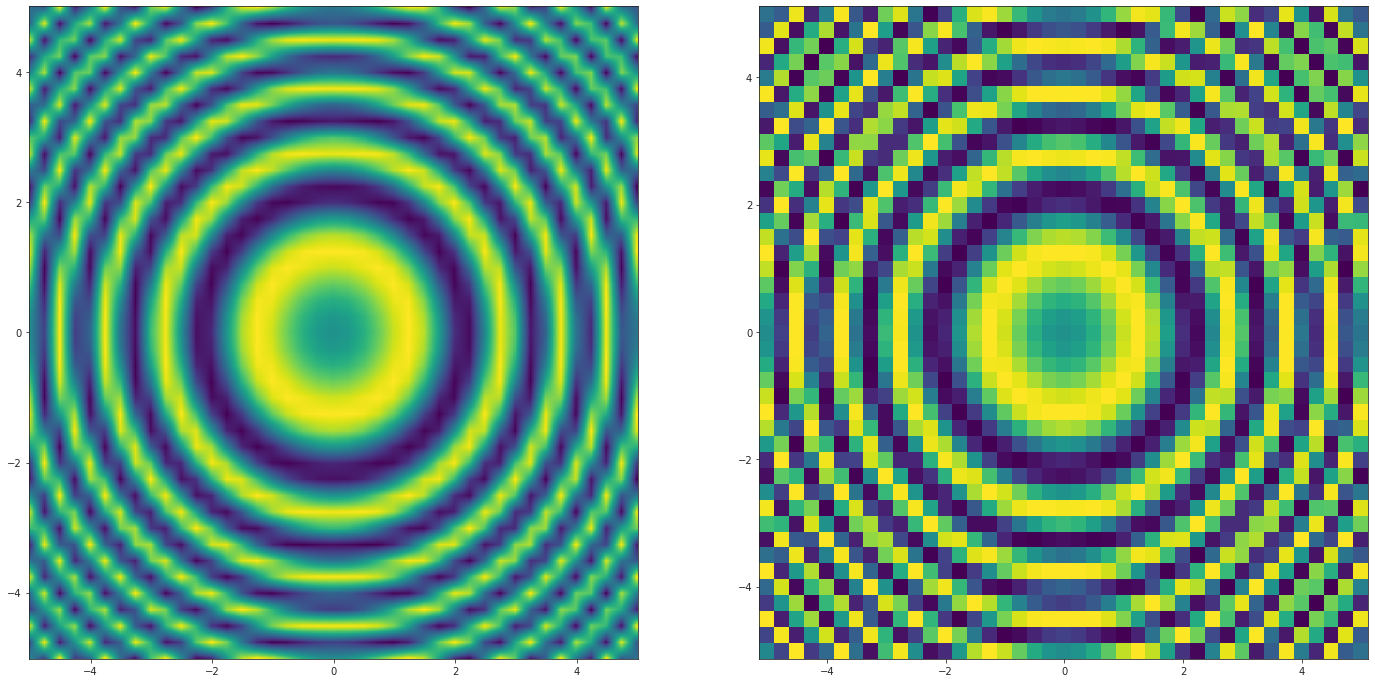

In [107]:
fig = plt.figure(figsize=(24, 12))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.pcolormesh(xnew_example, ynew_example, znew_example, cmap='viridis')
ax2.pcolormesh(xx_example, yy_example, z_example, cmap='viridis')

#### Apply this idea to a set of points in Hydra-Centaurus that more or less represents its background density

In [71]:
#Defining the points at which I will estimate the background
ra_bg = np.array([176.80, 171.04, 163.32, 155.78, 154.55, 163.27, 158.79, 159.63, 154.01, 150.83, 158.86])
dec_bg = -np.array([22.52, 22.78, 23.42, 23.79, 28.92, 34.51, 32.86, 42.04, 45.48, 46.05, 46.05])

radius = 1.0

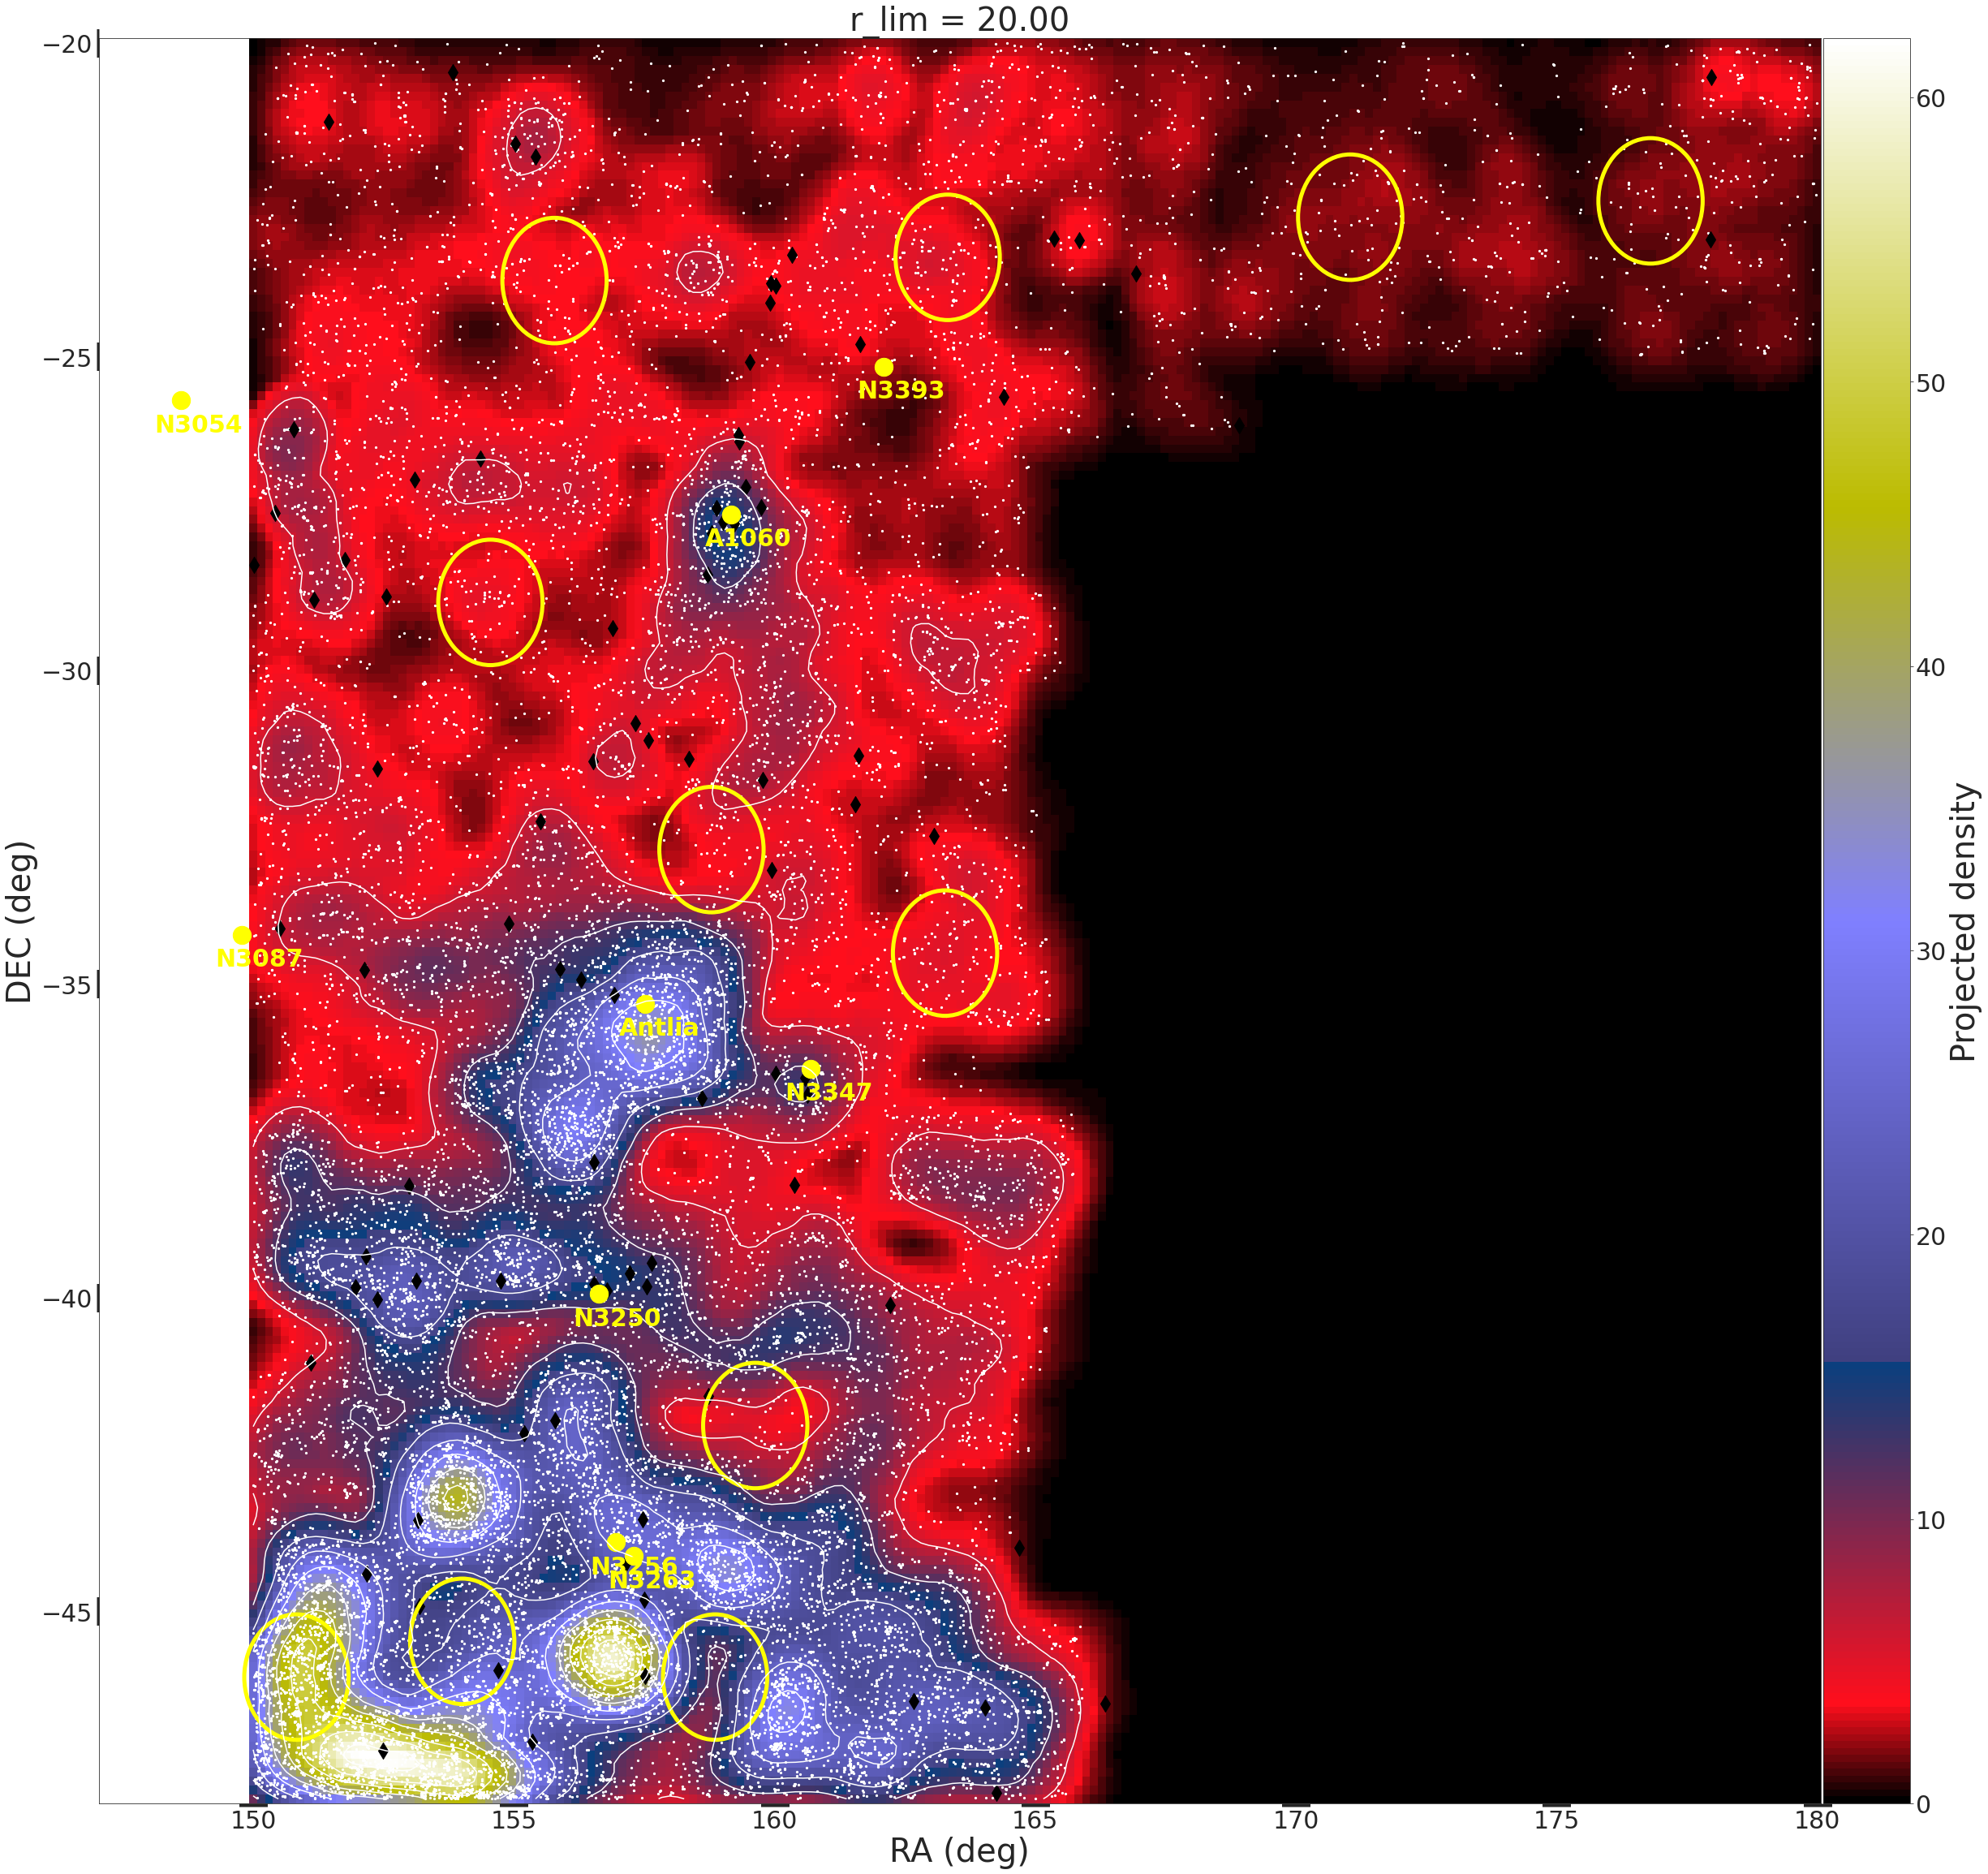

In [227]:
fontsize = 40
labelsize = 30

fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111)
sc1 = ax.pcolormesh(np.rad2deg(xx), np.rad2deg(yy), zz, cmap='gist_stern')
ax.scatter(np.rad2deg(x), np.rad2deg(y), s=5, color='white')
ax.set_title("Bandwidth = {:.4f}".format(bandwidth), fontsize=fontsize)
ax.set_ylabel("DEC (deg)", fontsize=fontsize)
ax.set_xlabel("RA (deg)", fontsize=fontsize)
ax.set_title("r_lim = {:.2f}".format(mlim), fontsize=40)

ax.scatter(x=ra_s[mask_s], y=dec_s[mask_s], s=200, color="black", marker="d")
ax.contour(np.rad2deg(xx), np.rad2deg(yy), zz, colors='white', levels=10, extend='min')


from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="Projected density", fontsize=fontsize)
cbar.ax.tick_params(labelsize=labelsize)

# ax.legend(fontsize=fontsize*0.8)
ax.xaxis.set_tick_params(labelsize=labelsize, width=35)
ax.yaxis.set_tick_params(labelsize=labelsize, width=35)

for ra_bg_i, dec_bg_i in zip(ra_bg, dec_bg):
    circle = plt.Circle((ra_bg_i, dec_bg_i), radius, linestyle='-', edgecolor='yellow', facecolor="None", lw=5)
    ax.add_patch(circle)
#     ax.scatter(ra_bg, dec_bg, s=500, color="orange")

dx = 0.5
for ra_i, dec_i, text in zip(cl_ras, cl_decs, cl_names):
    ax.scatter(ra_i, dec_i, marker='o', s = 500, color="yellow")
    ax.text(ra_i-dx, dec_i-dx, s=text, fontsize=30, fontweight='bold', color='yellow')
    
# ax.invert_xaxis()

In [52]:
median_density = []
for ra_bg_i, dec_bg_i in zip(np.deg2rad(ra_bg), np.deg2rad(dec_bg)):
    distances_i = haversine(ra_bg_i, dec_bg_i, xx, yy)
    circle_i = (distances_i < np.deg2rad(radius))
    median_density_i = np.median(zz[circle_i])
    median_density.append(median_density_i)

median_density = np.asarray(median_density)

In [85]:
interpolated_background = interpolate.interp2d(np.deg2rad(ra_bg), np.deg2rad(dec_bg), 
                                        median_density, kind='linear')

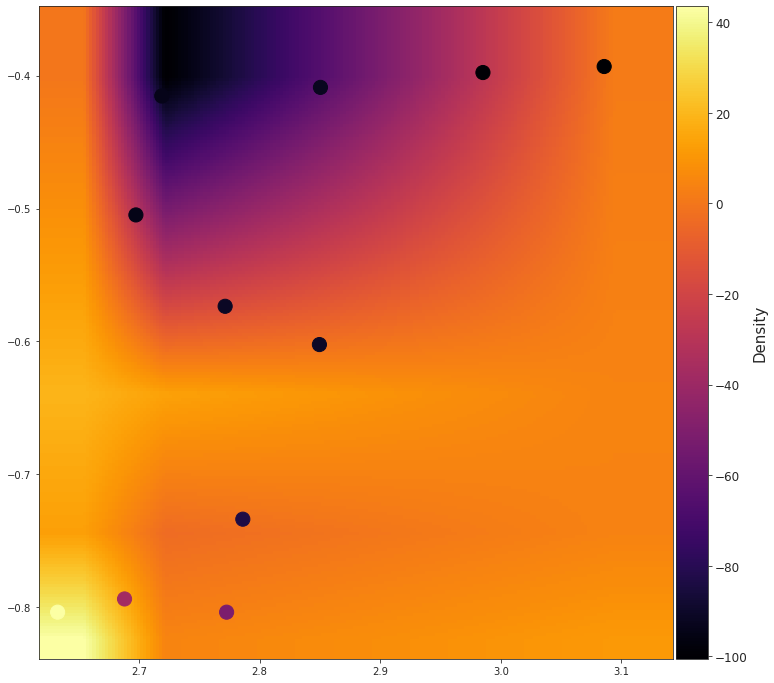

In [88]:
zz_new = interpolated_background(xx[:, 0], yy[0, :])

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
sc = ax.pcolormesh(xx, yy, zz_new, cmap='inferno')
ax.scatter(np.deg2rad(ra_bg), np.deg2rad(dec_bg), c=median_density, cmap="inferno", s=200)

# for ax, sc in zip([ax1, ax2], [sc1, sc2]):
divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax1, orientation='vertical')
cbar.set_label(label="Density", fontsize=15)
cbar.ax.tick_params(labelsize=12)

#### This idea is not working. To interpolate properly, I have to create a grid of coordinates at which I will estimate the background density

My idea is to divide the Hydra-Centaurus field by stripes in right ascension and declination. I will then somehow estimate the background for each stripe, both in RA and DEC, and pick the average value of density between both. I can make this so that I create a grid with bind 5 times bigger than the original grid, and then estimate the background by interpolating this more sparse grid into the original, thinner grid.<br>

I think it is important to first eliminate the bins with 0 density, because they can affect the final result (the 0 density is not real data, they are just regions with no observations)

In [205]:
median_ra_by_dec = np.array([np.median(zz[i:i+5, :], axis=0) for i in range(0, len(zz), 5)])

median_dec_by_ra = np.array([np.median(zz[:, i:i+5], axis=1) for i in range(0, len(zz), 5)])

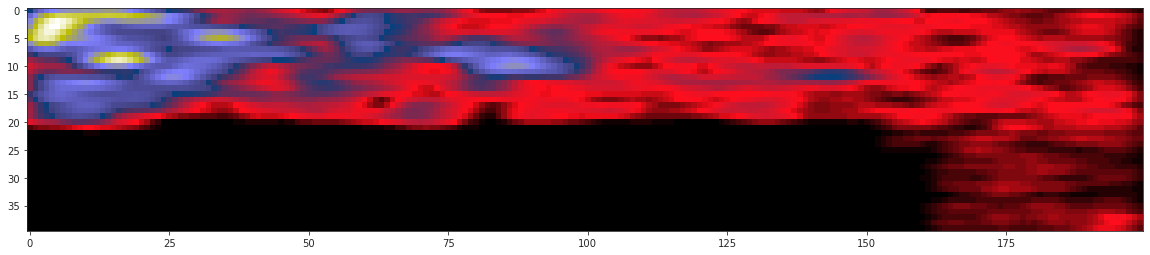

In [216]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.imshow(median_ra_by_dec, cmap="gist_stern")
# ax.invert_yaxis()
# ax.invert_xaxis()

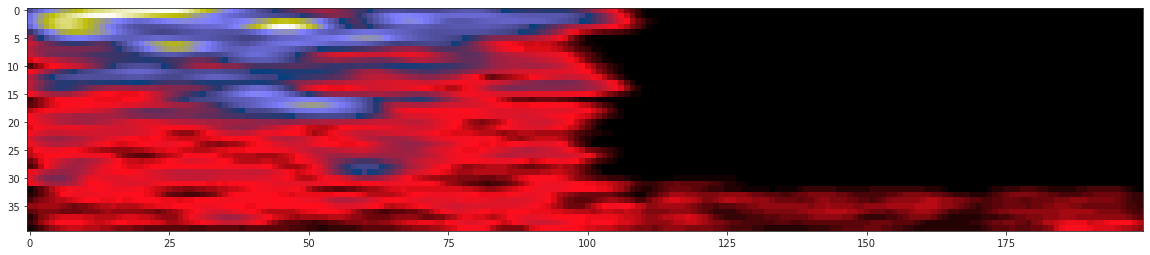

In [217]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
ax.imshow(median_dec_by_ra, cmap="gist_stern")
# ax.invert_yaxis()
# ax.invert_xaxis()

In [207]:
median_ra_by_dec_by_ra = np.median(median_ra_by_dec, axis=1)

median_dec_by_ra_by_dec = np.median(median_dec_by_ra, axis=1)

Text(0.5, 1.0, 'Median density as function of declination for each stripe in Right Ascension')

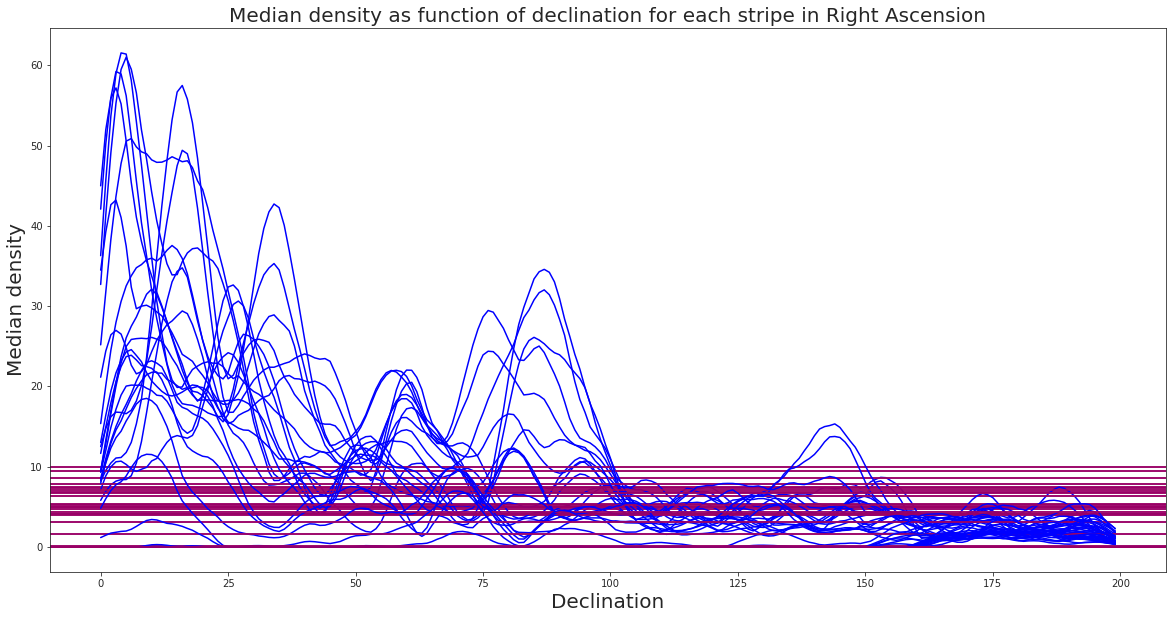

In [211]:
fontsize=20
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

for i in range(len(median_ra_by_dec)):
    ax.plot(np.arange(0, np.size(median_ra_by_dec, axis=1)), median_ra_by_dec[i, :], color="blue")
    ax.axhline(np.median(median_ra_by_dec[i, :]), color="red")
    ax.axhline(median_ra_by_dec_by_ra[i], color="purple")
    
ax.set_xlabel("Declination", fontsize=fontsize)
ax.set_ylabel("Median density", fontsize=fontsize)
ax.set_title("Median density as function of declination for each stripe in Right Ascension", fontsize=fontsize)

Text(0.5, 1.0, 'Median density as function of right ascencion for each stripe in declination')

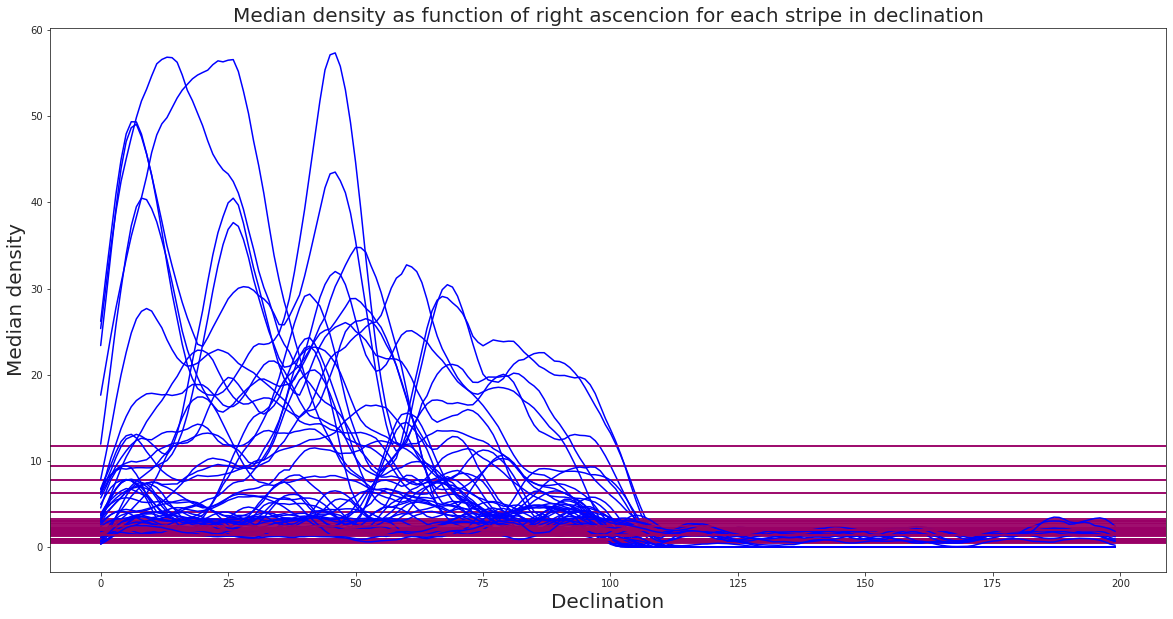

In [213]:
fontsize=20
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

for i in range(len(median_dec_by_ra)):
    ax.plot(np.arange(0, np.size(median_dec_by_ra, axis=1)), median_dec_by_ra[i, :], color="blue")
    ax.axhline(np.median(median_dec_by_ra[i, :]), color="red")
    ax.axhline(median_dec_by_ra_by_dec[i], color="purple")
    
ax.set_xlabel("Declination", fontsize=fontsize)
ax.set_ylabel("Median density", fontsize=fontsize)
ax.set_title("Median density as function of right ascencion for each stripe in declination", fontsize=fontsize)

In [239]:
median_by_dec = np.median(zz, axis=0)

median_by_ra = np.median(zz, axis=1)

In [219]:
background_sparse = np.array([(median_ra_by_dec_by_ra[i] + median_dec_by_ra_by_dec)/2 
                                     for i in range(len(median_ra_by_dec_by_ra))])

In [253]:
background = np.array([(0.0*np.flip(median_by_dec)[i] + median_by_ra)
                                     for i in range(len(median_by_dec))])

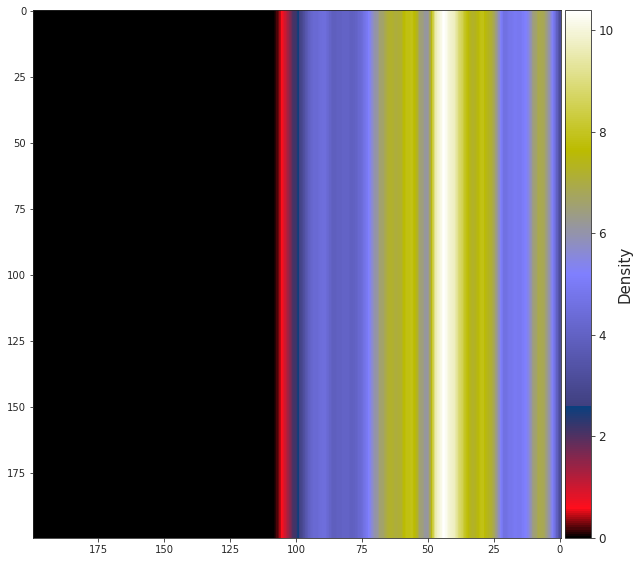

In [254]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
sc = ax.imshow(background, cmap="gist_stern")

divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax1, orientation='vertical')
cbar.set_label(label="Density", fontsize=15)
cbar.ax.tick_params(labelsize=12)

# ax.invert_yaxis()
ax.invert_xaxis()